In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Метрики качества классификации

Используется множество различных метрик качества классификации, большое распространение получили следующие:

1. accuracy - какую долю объектов мы классифицироввали правильно. Данная метрика крайне неустойчива к дисбалансу классов
2. precision - сколько объектов, предсказанных, как первый класс, действительно относятся к первому классу
3. recall - какую долю объектов 1го класса мы предсказали верно
4. F1-score - 2 * precision * recall / (precision + recall).
5. specifity - какую долю объектов 0 класса правильно отнесли к нулевому классу

Если наш классификатор для каждого объекта выдавать число, характеризующее вероятность этого объекта принадлежать к первому классу, то можно использовать следующие две метрики:

6. ROC-AUC - площадь под ROC-AUC кривой  

Для каждого порога на значение, выдаваемое классификатором, считаем precision и 1 -specifity. Строим кривую по точкам. Считаем под ней площадь. 

Площадь для идеального классификатора - 1. Площадь для случайного - 0.5, но для случаев большого дисбаланса классов очень вероятны значения roc-auc, близкие к 1 даже для очень плохого классификатора 


7. PR-AUC - площадь под PR-AUC кривой

Для каждого порога на значение, выдаваемое классификатором, считаем precision и recall. Строим кривую по точкам. Считаем под ней площадь -  P/(P+N)

Площадь для идеального классификатора - 1. Площадь для случайного - отношение числа объектов положительного класса к числу объектов отрицательного. 


In [122]:
from sklearn.metrics import (roc_auc_score,
                             average_precision_score, # PR-AUC
                             accuracy_score,
                             f1_score)


# Наивный байес 

Загрузите из https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/ обучающую выборку. Будем работать с ней и считать, что другого датасета у нас нет

In [158]:
# Выберем только полные предложения
dt = pd.read_table("train.tsv")
dt["Length"] = dt['Phrase'].apply(lambda x: len(x))
dt.sort_values(by=['SentenceId', "Length"], ascending=[True, False])
dt = dt.drop_duplicates(subset="SentenceId", keep='first')

In [159]:
dt.loc[:, 'Positive'] = dt['Sentiment'] > 2 # будем предказывать позитивные ревью

**(0.5 балла)** Объясните, что делает приведенный ниже код

In [188]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words="english",
                             max_df=0.9,
                             min_df=0.001)

X = vectorizer.fit_transform(dt['Phrase'].to_list())

In [189]:
Y = dt['Positive']

Разобьем выборку на train и test

In [190]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=777)

In [191]:
from sklearn.naive_bayes import MultinomialNB

In [192]:
classifier = MultinomialNB(alpha=10)
classifier.fit(X_train, Y_train)

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)

In [193]:
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)[:, 1]
print("Class balance: ", Y_test.mean())
print("ROC-AUC", roc_auc_score(y_score=y_pred_prob, y_true=Y_test))
print("PR-AUC", average_precision_score(y_score=y_pred_prob, y_true=Y_test))
print("F1-score", f1_score(y_pred=y_pred, y_true=Y_test))
print("Accuracy", accuracy_score(y_pred=y_pred, y_true=Y_test))

Class balance:  0.43688940992575226
ROC-AUC 0.7673434766901835
PR-AUC 0.7318012043335601
F1-score 0.6210796915167095
Accuracy 0.7119968737788198


Попробуем подобрать значение параметра alpha, которое даст нам наибольшее качество на кроссвалидации

In [194]:
from sklearn.model_selection import KFold

In [177]:
kfolder = KFold(n_splits=5, shuffle=True, random_state=777)

# Таким образом получаем 5 различных разбиений на train и validation.
for train_ids, val_ids in kfolder.split(X_train):
    print(train_ids.shape[0], val_ids.shape[0])

4776 1194
4776 1194
4776 1194
4776 1194
4776 1194


**(1.5 балла)** Подберите значение alpha, которое дает максимальное среднее f1-score по разбиениям. Используя полученное alpha обучите модель и проверьте качество на тесте. Можно использовать другие функции sklearn для кроссвалидации, вместо KFold

(**1 балл**) Обучите на том же наборе признаков KNNClassifier, подобрав для него число соседей. Сравните качество классификаторов

## GaussianNB

Как мы обсуждали раньше, в принципе, наивный байес может работать и с числами

In [206]:
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.datasets import make_moons, make_circles, make_classification


In [200]:
clf = GaussianNB(var_smoothing=1e-9)

In [282]:

X, Y = make_classification(n_features=2, 
                                       n_redundant=0,
                                       n_informative=2,
                                       random_state=20, 
                                       n_clusters_per_class=1,
                                       flip_y=0.02, 
                                       n_samples=500)

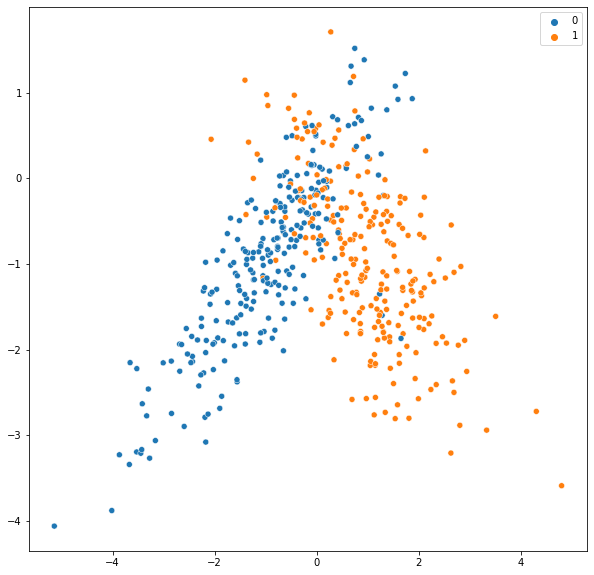

In [283]:

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y)
plt.show()

**(0.5 балл)** По аналогии с предыдущей домашней работой, постройте decision border для GaussianNB

\* **(1 допбалл)** Исследуйте влияние параметра var_smoothing на decision border GaussianNB

# Метод опорных векторов (SVM)

In [4]:
from sklearn.svm import SVC

In [5]:
from sklearn import datasets 
import numpy as np
import matplotlib.pyplot as plt

## C = inf

In [3]:
iris = datasets.load_iris() # датасет с данными об ирисах, собранный Фишером, содержит три вида ирисов
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1) 
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

Обучим классификатор с бесконечным штрафом за неправильную классификацию 

In [4]:
svm_clf = SVC(kernel="linear", C=np.inf) 
svm_clf.fit(X, y)

SVC(C=inf, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
# handson-ml course 
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

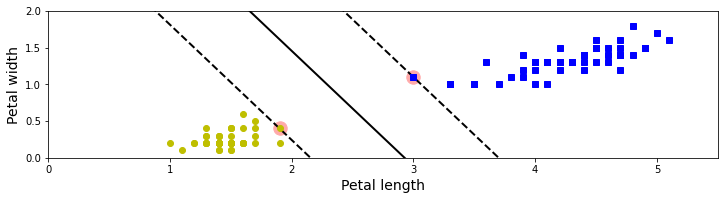

In [6]:
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

plt.figure(figsize=(12,2.7))

plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.ylabel("Petal width", fontsize=14)
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])
plt.show()

**(0.25 балла)** Подпишите на графике опорные вектора. Что они собой представляют?

Добавим один выброс

In [7]:
svm_clf = SVC(kernel="linear", C=np.inf) 
X_out = np.concatenate([X, np.array([3.2, 0.8]).reshape(1, 2)], axis=0)
y_out = np.concatenate([y, np.array([0])])

svm_clf.fit(X_out, y_out)

SVC(C=inf, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

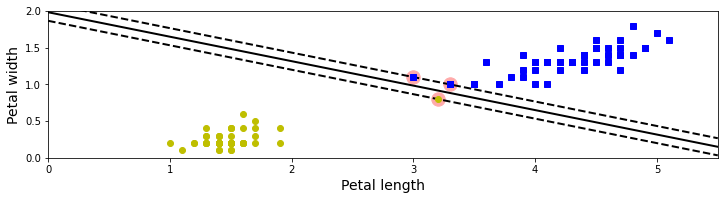

In [8]:
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

plt.figure(figsize=(12,2.7))

plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X_out[:, 0][y_out==1], X_out[:, 1][y_out==1], "bs")
plt.plot(X_out[:, 0][y_out==0], X_out[:, 1][y_out==0], "yo")
plt.ylabel("Petal width", fontsize=14)
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])
plt.show()

**(0.25 балла)** Объясните, почему полученное решение плохое. 

Теперь добавим другой выброс

In [10]:
X_out = np.concatenate([X, np.array([3.4, 1.3]).reshape(1, 2)], axis=0)
y_out = np.concatenate([y, np.array([0])])



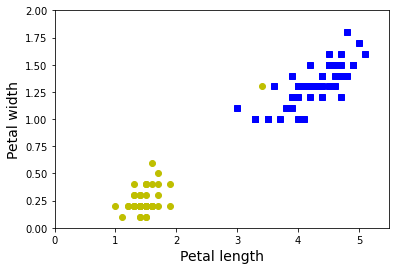

In [11]:
plt.plot(X_out[:, 0][y_out==1], X_out[:, 1][y_out==1], "bs")
plt.plot(X_out[:, 0][y_out==0], X_out[:, 1][y_out==0], "yo")
plt.ylabel("Petal width", fontsize=14)
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])
plt.show()

**(0.75 балла)** Объясните, почему ниже расположенная строчка кода приводит к зависанию

In [ ]:
svm_clf = SVC(kernel="linear", C=np.inf) 
svm_clf.fit(X_out, y_out)

## Чувствительность к масштабу признаков

(-2.0, 2.0, -2.0, 2.0)

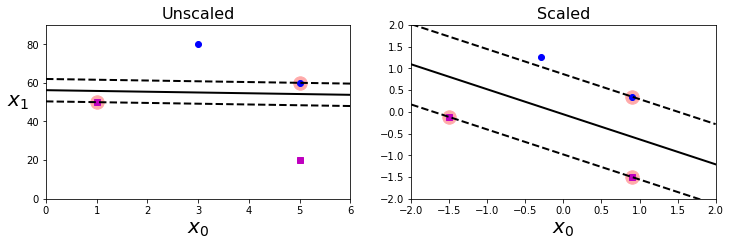

In [46]:
# handson-ml course 

Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$  ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

**(0.25 балла)** Чувствителен ли SVM к масштабу признаков? 

**(0.75 балла)** Возьмите датасет wine is sklearn, используйте первые два признака. Учите классификатор отличать 0 класс вина от остальных. Проявляется ли в данном случае чувствительность SVM к масштабу признаков?

In [47]:
wine_dataset = datasets.load_wine()

**(1 балл)** Какой еще алгоритм из разобранных ранее крайне чувствителен к масштабу признаков? Продемонстируйте

# Разные значения C

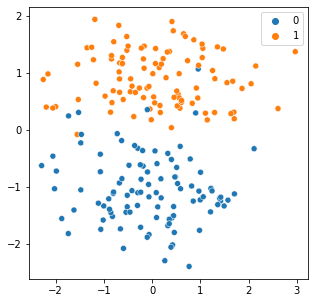

In [63]:
X, Y = datasets.make_classification(n_features=2, 
                                       n_redundant=0,
                                       n_informative=1,
                                       random_state=202, 
                                       n_clusters_per_class=1,
                                       flip_y=0, 
                                       n_samples=200)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
sns.scatterplot(x=X[:, 1], y=X[:, 0], hue=Y)
plt.show()

**(1 балл)** Продемонстрируйте (при помощи графиков и используя датасет, сгенерированный в предыдущей ячейке), как меняется граница решений для kernel="linear" в зависимости от значения C

**(0.25 балла)** Как связан bias-variance trade-off с значением параметра C

## Разные ядра

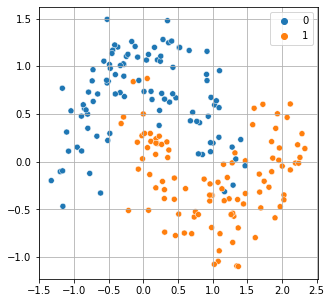

In [77]:
X, Y = datasets.make_moons(n_samples=200, 
                           noise=0.25,
                           random_state=200)
plt.figure(figsize=(5,5))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y)
plt.grid(True, which='both')
plt.show()

In [86]:
# handson-ml course 

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 500)
    x1s = np.linspace(axes[2], axes[3], 500)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

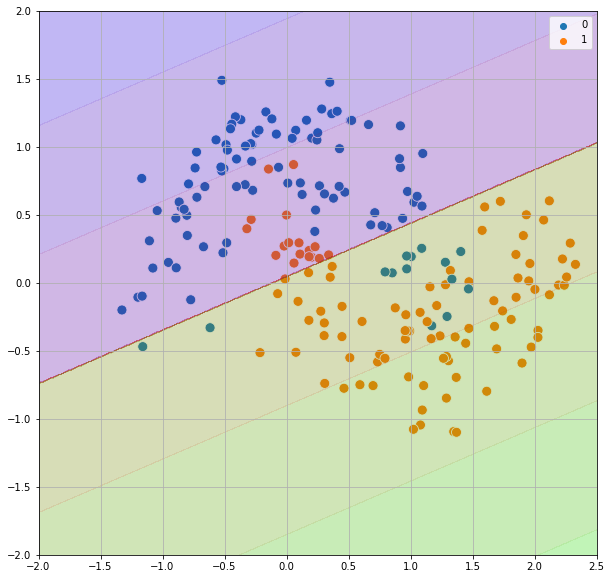

In [116]:
svm = SVC(kernel="linear", C=10)
svm.fit(X, Y)
plt.figure(figsize=(10,10))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y, s=100)
plt.grid(True, which='both')
plot_predictions(svm, [-2, 2.5, -2, 2])
plt.show()

**(0.5 балла)** Постройте decision border для kernel="poly" для значений degree 3, 5, 10 и 20. C поставьте равным 10 

**(0.25 балла)** Используя построенные графики скажите, какая степень полинома дает лучшее решение?  

**(0.25 балла)** Как думаете, будет ли зависеть потребление памяти моделью от степени полинома?

\* **(0.5 допбалла)** Проверьте свои догадки при помощи функции memit jupyter-notebook https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

**(0.5 балла)** Постройте decision border для kernel="rbf" для значений gamma=0.1, 3 и 0.5 и C =0.001, 1000.

**(0.5 балла)** Как влияет rbf на bias и variance модели?

\* **(1.5 допбалла)** На рисунке, который вы получите для gamma=5, C=1000, есть области, в которых нет никаких точек. 

Эти области "явно" расположены ближе к синим точкам, чем к желтым. 

Однако, по какой-то причине, модель в этих областях принимает решение не в пользу синих точек. 

Почитайте подробнее про то, как устроено ядро rbf и попытайтесь объяснить наблюдаемый феномен

## Plat scaling

Что мы хотим видеть для вероятностей, предсказываемых идеальным классификатором?

Мы хотим, чтобы доля объектов, принадлежащих классу X, для которых классификатор выдал вероятность p принадлежать классу X, была равна p

Если разбить все наши объекты на бины по предсказываемым вероятностям, то можно для каждого бина посчитать долю объектов целевого класса и построить полученную зависимость. В идеале должна получиться прямая

In [163]:
# sklearn
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
def plot_calibration_curve(clf, X_test, Y_test, name='classifier'):
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    y_pred = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    clf_score = brier_score_loss(Y_test, prob_pos, pos_label=y.max())
    fraction_of_positives, mean_predicted_value = \
            calibration_curve(Y_test, prob_pos, n_bins=10)

    plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                label="%s Score=(%1.3f)" % (name, clf_score))


    plt.ylabel("Fraction of positives")
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="best")

In [164]:
from sklearn.model_selection import train_test_split

In [168]:
X, Y = datasets.make_classification(n_samples=10000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=777)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.99,
                                                    random_state=777)

In [172]:
svm = SVC(kernel="linear")
svm.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

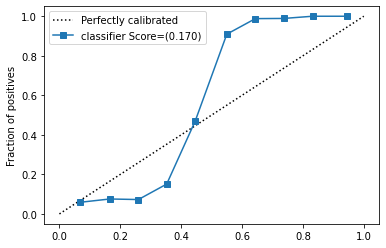

In [173]:
plot_calibration_curve(svm, X_test, Y_test)

**(0.25 балла)** Что такое brier_score_loss, который мы выводим на графике. Что он считает?

**(0.5 балла)** Постройте такие же графики для LogisticRegression и GaussianNB, а также для SVM с полиномиальным и rbf ядрами (остальныые параметры оставьте по-умолчанию). Какой(ие) из обученных классификаторов дает кривую, близкую к идеальной? 

В sklearn существует два метода, позволяющие получить для классификатора "откалиброванную вероятность" - то есть вероятность, которая больше похожа на вероятность, выдаваемую идеальным классификатором. 

Первый из них использует логистическую регрессию, которая учится на основе вероятности или величины decision function, которую модель выдает для конкретного объекта, предсказывать для него "правильную" вероятность.

Второй использует изотоническую регрессию, которая делает так же

**(0.25 балла)** Почему нельзя учить регрессию, предсказывающую "поправленную" вероятность, на той же выборке, на которой мы учили классификатор?

**(0.25 балла)** Как это делает CalibratedClassifierCV из sklearn? Прочтите документацию и кратко опишите. 

**(1 балла)** С помощью CalibratedClassifireCV постройте модель, в основе которой лежит SVM, которая выдает откалиброванные вероятности. Постройте калибровочную кривую для method='isotonic' и method='sigmoid'. Сравните их, напишите, какой в этом случае дал кривую более близкую к идеальной 

# Мультиклассовый SVM

## 1 vs rest

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml


In [6]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [7]:
X = mnist["data"]
Y = mnist["target"]

X = X[0:12000]
Y = Y[0:12000]


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=777)

In [ ]:
lin_clf = SVC(random_state=42, kernel='linear', decision_function_shape='ovr')
lin_clf.fit(X_train, Y_train)
y_pred = lin_clf.predict(X_test)

In [13]:
accuracy_score(Y_test, y_pred)

0.9175

**(0.5 балла)** Используйте StandardScaler из sklearn, чтобы отнормировать признаки в X. Обучите модель с линейном ядром на отшкалированном X. Изменилось ли качество в лучшую сторону?

Попробуем подобрать параметры SVM. Будем использовать ядро rbf, и попробуем найти хорошие значения gamma  и С. 
Для этого примением функцию RandomizedSearchCV

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}

In [15]:
?RandomizedSearchCV

Чему равно качество подобранной модели?

## 1 vs 1 

**(1.5 балла)** Попробуйте использовать в SVM стратегию one vs one. Параметры SVM используйте те же, что были подобраны при помощи RandomizedSearchCV на прошлом этапе. Сравните качество модели с предыдущей

# Кроссвалидация

## "Парадокс"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

Создадим таблицу 200 на 10000 со "здоровыми" и "больными" пациентами и данными об "экспрессии" их генов. 


In [ ]:
gene_count = 10000
genes = [f"Gene{ind}" for ind in range(gene_count)]
healthy = pd.DataFrame(np.random.normal(size=(100, gene_count), 
                                        loc=0, 
                                        scale=1), 
                       columns=genes)
healthy['State'] = "H"
diseased = pd.DataFrame(np.random.normal(size=(100, gene_count), 
                                         loc=0, 
                                         scale=1),
                        columns=genes)
diseased['State'] = "D"
patients = pd.concat([healthy, diseased], axis=0)

In [ ]:
patients

In [ ]:
X = patients.drop("State", axis=1)
Y = patients['State']

In [ ]:
top_k = 10

diffs = X[Y == "H"].mean(axis=0) - X[Y == 'D'].mean(axis=0)
top = np.abs(diffs).sort_values(ascending=False)[0:top_k]
genes = top.index

In [ ]:
X_selected = X[genes]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, Y == "D", test_size=0.3)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)


In [ ]:
y_train_pred = model.predict_proba(X_train)[:, 1]
train_rocauc = roc_auc_score(y_score=y_train_pred, y_true=y_train)
train_prauc = average_precision_score(y_score=y_train_pred, y_true=y_train)
train_accuracy = accuracy_score(y_pred=y_train_pred > 0.5, y_true=y_train)
print("Train quality:")
print(f"ROCAUC : {train_rocauc:.02f}")
print(f"PRAUC : {train_prauc:.02f}")
print(f"Accuracy: accuracy {train_accuracy:.02f}")

In [ ]:
y_test_pred = model.predict_proba(X_test)[:, 1]
train_rocauc = roc_auc_score(y_score=y_test_pred, y_true=y_test)
train_prauc = average_precision_score(y_score=y_test_pred, y_true=y_test)
train_accuracy = accuracy_score(y_pred=y_test_pred > 0.5, y_true=y_test)
print("Test quality:")
print(f"ROCAUC : {train_rocauc:.02f}")
print(f"PRAUC : {train_prauc:.02f}")
print(f"Accuracy: accuracy {train_accuracy:.02f}")

**(0.5 балла)** Очевидно, что мы не могли выучить никаких разумных признаков. Однако, мы их все же выучили... Объясните полученный парадокс

Тем не менее, может мы просто что-то делаем не так. Попробуем встроенные в sklearn методы для выбора признаков

In [ ]:
from sklearn.feature_selection import (SelectKBest, SelectFdr, SelectFwe,
                                       SelectPercentile, f_classif)

In [ ]:
X_selected = SelectKBest(f_classif, k=10).fit_transform(X, Y)

**(0.5 балла)** Повторите все на отобранных стандартным методом sklearn признаках. Результат объясните

**(0.5 балла)** Что делает метод выделения признаков SelectFdr? Что такое FDR? Опишите ниже

**(0.5 балла)** Примените метод SelectFdr. Результат объясните

**(0.5 балла)** Почему вообще возникла проблема в начале? Объясните

**(0.5 балла)** Как бы эту проблему можно было бы избежать?

# \* Классификация открытого и закрытого хроматина

Скачайте последовательности открытых и закрытых участках хроматина в клеточной линии HepG2 - 
https://kodomo.fbb.msu.ru/FBB/ml/HepG2_positive.fasta
https://kodomo.fbb.msu.ru/FBB/ml/HepG2_negative_sample_final.fasta

В данном случае мы забываем про хромосомы, из которых пришли нам эти данные и потому бить на кросс-валидацию можно случайным образом

**(0.25 доп балла)** Прочитайте последовательности из файлов, разбейти их на обучающую и тестовую выборку

**(1 доп балл)** Напишите функцию, чтобы каждую последовательность закодировать в виде k-merов. 
Число k должно передаваться параметром

(**2 допбалла**) Подберите при помощи кроссвалидации модель SVM, которая выдает наилучшее качество. Также подберите наилучшее k.

Оцените качество полученной модели на тестовой выборке

**(3 допбалла)** Последовательности, которые мы используем, могут быть иногда похожи друг на друга. Хотелось бы, чтобы слишком похожие последовательности (например, по k-мерному составу похожие больше чем на 95%) оказывались либо все вместе в обучении, либо все вместе - в тесте. 
Реализуйте функцию, которая это делает. Повторите предыдущие шаги по построению модели

**(2 допбалла)** Выберите n последовательностей, которые модель скорит наиболее высоко и n последовательностей, которые моделей скорит наиболее низко. Можно выполнять этот пункт как и для модели построенной для предыдущего пункта, так и для модели, построенной ранее.  С помощью ChipMunk или MEME попробуйте найти в первой и во второй группах последовательностей мотив/мотивы. 
